In [1]:
import os
import torch
import torchaudio
import soundfile as sf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tqdm.auto import tqdm
from transformers import (
    AutoFeatureExtractor,
    Wav2Vec2ForSequenceClassification,
    HubertForSequenceClassification
)

DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
SAMPLE_RATE = 16000
BATCH_SIZE = 8
EPOCHS = 10

CLASSES = ['down', 'left', 'off', 'on', 'right', 'stop', 'up']
NUM_CLASSES = len(CLASSES)

/opt/miniconda3/envs/Lesson_44/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_NAME = "superb/wav2vec2-base-superb-ks"
feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_NAME)


In [3]:
class SpeechCommandsDataset(Dataset):
    def __init__(self, root_dir, classes):
        self.files = []
        self.labels = []
        self.classes = classes

        for label, cls in enumerate(classes):
            cls_dir = os.path.join(root_dir, cls)
            for fname in os.listdir(cls_dir):
                if fname.endswith(".wav"):
                    self.files.append(os.path.join(cls_dir, fname))
                    self.labels.append(label)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        wav_np, sr = sf.read(self.files[idx], dtype="float32")
        waveform = torch.from_numpy(wav_np)

        if waveform.ndim == 1:
            pass
        else:
            waveform = waveform.mean(dim=1)

        if sr != SAMPLE_RATE:
            waveform = torchaudio.functional.resample(waveform, sr, SAMPLE_RATE)

        # Fixed length (1 sec) so DataLoader can stack tensors into a batch.
        target_len = SAMPLE_RATE
        if waveform.shape[0] < target_len:
            waveform = torch.nn.functional.pad(waveform, (0, target_len - waveform.shape[0]))
        else:
            waveform = waveform[:target_len]

        inputs = feature_extractor(
            waveform,
            sampling_rate=SAMPLE_RATE,
            return_tensors="pt",
            padding=True,
            return_attention_mask=True
        )

        input_values = inputs["input_values"].squeeze(0)
        attention_mask = inputs.get("attention_mask")
        if attention_mask is None:
            attention_mask = torch.ones_like(input_values, dtype=torch.long)
        else:
            attention_mask = attention_mask.squeeze(0)

        return {
            "input_values": input_values,
            "attention_mask": attention_mask,
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [4]:
DATA_ROOT = "speech_commands"

dataset = SpeechCommandsDataset(DATA_ROOT, CLASSES)

indices = list(range(len(dataset)))
labels = dataset.labels
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

train_ds = torch.utils.data.Subset(dataset, train_idx)
val_ds = torch.utils.data.Subset(dataset, val_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)


In [5]:
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True
)

model.to(DEVICE)

def get_backbone(m):
    if hasattr(m, "wav2vec2"):
        return m.wav2vec2
    if hasattr(m, "hubert"):
        return m.hubert
    raise ValueError("Model backbone is neither wav2vec2 nor hubert")

backbone = get_backbone(model)

for p in model.parameters():
    p.requires_grad = False

for p in model.classifier.parameters():
    p.requires_grad = True

if hasattr(model, "projector"):
    for p in model.projector.parameters():
        p.requires_grad = True

UNFREEZE_EPOCH = 2
N_UNFREEZE_LAYERS = 3
HEAD_LR = 3e-4
FT_LR = 5e-5
WEIGHT_DECAY = 1e-4

def build_optimizer(lr):
    return torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr,
        weight_decay=WEIGHT_DECAY
    )

optimizer = build_optimizer(HEAD_LR)


Loading weights: 100%|██████████| 216/216 [00:00<00:00, 1957.09it/s, Materializing param=wav2vec2.masked_spec_embed]                                            
Wav2Vec2ForSequenceClassification LOAD REPORT from: superb/wav2vec2-base-superb-ks
Key               | Status   |                                                                                        
------------------+----------+----------------------------------------------------------------------------------------
classifier.weight | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([12, 256]) vs model:torch.Size([7, 256])
classifier.bias   | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([12]) vs model:torch.Size([7])          

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.


In [6]:
best_acc = 0.0
best_epoch = 0

for epoch in range(EPOCHS):
    if epoch == UNFREEZE_EPOCH:
        if hasattr(backbone, "feature_projection"):
            for p in backbone.feature_projection.parameters():
                p.requires_grad = True

        for layer in backbone.encoder.layers[-N_UNFREEZE_LAYERS:]:
            for p in layer.parameters():
                p.requires_grad = True

        optimizer = build_optimizer(FT_LR)
        print(f"→ stage 2: разморозили последние {N_UNFREEZE_LAYERS} слоя, lr={FT_LR:.1e}")

    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in tqdm(train_loader, desc=f"Train {epoch+1}/{EPOCHS}"):
        optimizer.zero_grad()

        labels = batch["labels"].to(DEVICE)
        outputs = model(
            input_values=batch["input_values"].to(DEVICE),
            attention_mask=batch["attention_mask"].to(DEVICE),
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_loss /= len(train_loader)
    train_acc = train_correct / train_total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Val   {epoch+1}/{EPOCHS}"):
            labels = batch["labels"].to(DEVICE)
            outputs = model(
                input_values=batch["input_values"].to(DEVICE),
                attention_mask=batch["attention_mask"].to(DEVICE),
                labels=labels
            )

            loss = outputs.loss
            val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    print(
        f"[{epoch+1:2d}/{EPOCHS}] "
        f"train loss: {train_loss:.4f}  acc: {train_acc:.4f} | "
        f"val loss: {val_loss:.4f}  acc: {val_acc:.4f}"
    )

    if val_acc > best_acc:
        best_acc = val_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "best_wav2vec_speech.pt")
        print(f"→ новая лучшая модель, сохранена (acc = {val_acc:.4f})")

print(f"\nЛучшая валидационная точность: {best_acc:.4f} на эпохе {best_epoch}")


Val   1/10: 100%|██████████| 412/412 [01:13<00:00,  5.60it/s]


[ 1/10] train loss: 0.4547  acc: 0.9019 | val loss: 0.0937  acc: 0.9721
→ новая лучшая модель, сохранена (acc = 0.9721)


Val   2/10: 100%|██████████| 412/412 [01:07<00:00,  6.12it/s]


[ 2/10] train loss: 0.2459  acc: 0.9214 | val loss: 0.0877  acc: 0.9730
→ новая лучшая модель, сохранена (acc = 0.9730)
→ stage 2: разморозили последние 3 слоя, lr=5.0e-05


Val   3/10: 100%|██████████| 412/412 [01:09<00:00,  5.95it/s]


[ 3/10] train loss: 0.2153  acc: 0.9273 | val loss: 0.0779  acc: 0.9757
→ новая лучшая модель, сохранена (acc = 0.9757)


Val   4/10: 100%|██████████| 412/412 [01:07<00:00,  6.07it/s]


[ 4/10] train loss: 0.1812  acc: 0.9377 | val loss: 0.0765  acc: 0.9766
→ новая лучшая модель, сохранена (acc = 0.9766)


Val   5/10: 100%|██████████| 412/412 [01:07<00:00,  6.08it/s]


[ 5/10] train loss: 0.1711  acc: 0.9418 | val loss: 0.0754  acc: 0.9794
→ новая лучшая модель, сохранена (acc = 0.9794)


Val   6/10: 100%|██████████| 412/412 [01:07<00:00,  6.14it/s]


[ 6/10] train loss: 0.1572  acc: 0.9467 | val loss: 0.0740  acc: 0.9797
→ новая лучшая модель, сохранена (acc = 0.9797)


Val   7/10: 100%|██████████| 412/412 [01:07<00:00,  6.10it/s]


[ 7/10] train loss: 0.1477  acc: 0.9493 | val loss: 0.0795  acc: 0.9754


Val   8/10: 100%|██████████| 412/412 [01:07<00:00,  6.11it/s]


[ 8/10] train loss: 0.1456  acc: 0.9498 | val loss: 0.0945  acc: 0.9766


Val   9/10: 100%|██████████| 412/412 [01:09<00:00,  5.96it/s]


[ 9/10] train loss: 0.1372  acc: 0.9505 | val loss: 0.0749  acc: 0.9775


Val   10/10: 100%|██████████| 412/412 [01:09<00:00,  5.95it/s]

[10/10] train loss: 0.1328  acc: 0.9550 | val loss: 0.0719  acc: 0.9785

Лучшая валидационная точность: 0.9797 на эпохе 6


In [7]:
model.load_state_dict(torch.load("best_wav2vec_speech.pt", map_location=DEVICE))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for batch in val_loader:
        outputs = model(
            input_values=batch["input_values"].to(DEVICE),
            attention_mask=batch["attention_mask"].to(DEVICE)
        )

        preds = torch.argmax(outputs.logits, dim=1)

        y_true.extend(batch["labels"].numpy())
        y_pred.extend(preds.cpu().numpy())

Validation accuracy: 0.9797
              precision    recall  f1-score   support

        down     0.9914    0.9851    0.9883       470
        left     0.9850    0.9809    0.9829       470
         off     0.9744    0.9703    0.9723       471
          on     0.9767    0.9788    0.9777       471
       right     0.9978    0.9809    0.9893       471
        stop     0.9707    0.9851    0.9779       471
          up     0.9623    0.9766    0.9694       471

    accuracy                         0.9797      3295
   macro avg     0.9798    0.9797    0.9797      3295
weighted avg     0.9798    0.9797    0.9797      3295



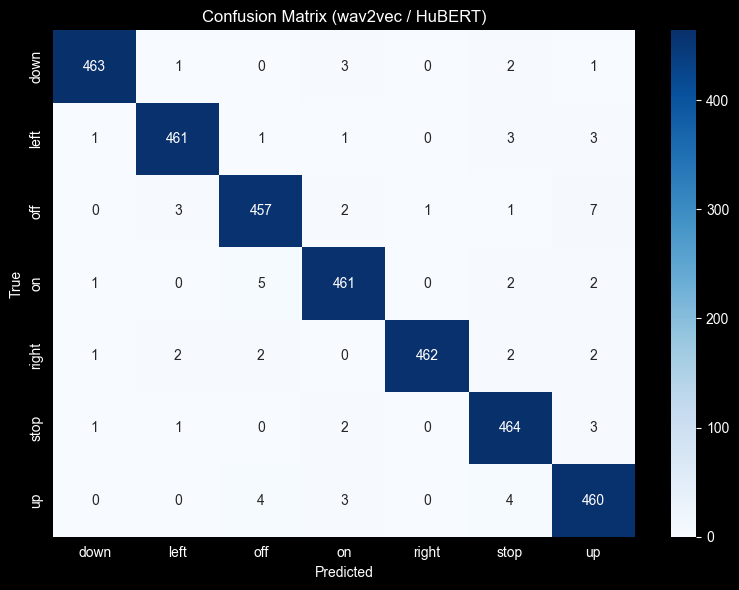

In [8]:
acc = accuracy_score(y_true, y_pred)
print(f"Validation accuracy: {acc:.4f}")

print(
    classification_report(
        y_true,
        y_pred,
        target_names=CLASSES,
        digits=4
    )
)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    cmap="Blues"
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (wav2vec / HuBERT)")
plt.tight_layout()
plt.show()